# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for MTRs

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.mtr_parser as mtr_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2023/Moorings/23bs4a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/mtr/4118_Data.TXT'
instrument = 'MTR 4118'
mooring_meta_file = user_data_dir+'logs/23BS-4A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/mtr_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'mt'

#
mtr_coef = [1.1105397541E-03,5.2476546372E-04,2.3382101485E-06] #2022 cal
time_offset_seconds = 0*60 + 1
###############################################################

#init and load data
mtr_wop = mtr_parser.mtr()
(mtr_wop_data,mtr_wop_header) = mtr_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True,
                                                    version=4.1) 

The data is output as a pandas dataframe from the intial module call and if its available, a header

In [4]:
mtr_wop_header

['',
 '',
 'Quit logging? Y or (N) Y',
 '',
 'PMEL MTR revision = V4.00 December 4, 1996',
 'MTR serial number = 4118',
 'MTR time/date     = 22:28:09 10/23/2024',
 'Start time/date   = 00:00:00 08/15/2023',
 'Sample interval   = 00:10:00',
 'Records logged    = 524',
 'Extra samples     = 15',
 '',
 "Command Mode: Type 'help' for command list.",
 'CMD> STATUS',
 '',
 'PMEL MTR revision = V4.00 December 4, 1996',
 'MTR serial number = 4118',
 'MTR time/date     = 22:29:15 10/23/2024',
 'Start time/date   = 00:00:00 08/15/2023',
 'Sample interval   = 00:10:00',
 'Records logged    = 524',
 'Extra samples     = 15',
 'CMD> READ DATA']

In [5]:
mtr_wop_data = mtr_wop.hex2dec(mtr_wop_data)

In [6]:
#10min batches represent a two hour grouping, 10 groupings for a 20hour window
mtr_wop_data = mtr_wop.res2temp(mtr_wop_data,mtr_coef)

In [7]:
mtr_wop_df = mtr_wop.dic2df(mtr_wop_data)

### Special note for MTR times

Historically these instruments have drifted significantly.  (usually to be slow) We keep track of the shift in seconds. 

In [8]:
mtr_wop_df = mtr_wop.time_correction(mtr_wop_df, offset=time_offset_seconds) #positive to catch up with GPS time - linear correction may need to be applied... this is an offset shift at the moment 
mtr_wop_df

(                               temperature
 date_time                                 
 2023-08-15 00:00:00.000000000    12.843674
 2023-08-15 00:10:00.000015903    13.135272
 2023-08-15 00:20:00.000031806    13.185575
 2023-08-15 00:30:00.000047709    13.329432
 2023-08-15 00:40:00.000063612    13.477110
 ...                                    ...
 2024-10-24 15:10:00.999901125     0.000000
 2024-10-24 15:20:00.999917028     0.000000
 2024-10-24 15:30:00.999932931     0.000000
 2024-10-24 15:40:00.999948834     0.000000
 2024-10-24 15:50:00.999964737     0.000000
 
 [62880 rows x 1 columns],
 15903)

## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

In [9]:
mtr_wop_df = mtr_wop_df[0].resample('1min').mean().interpolate().resample('10min').last() #this puts data on 1min then interpolates to it, then retrieves the data every 10min by subsetting
mtr_wop_df

,temperature
date_time,
2023-08-15 00:00:00,13.106112
2023-08-15 00:10:00,13.180545
2023-08-15 00:20:00,13.315046
2023-08-15 00:30:00,13.462342
2023-08-15 00:40:00,13.581255
...,...
2024-10-24 15:10:00,0.000000
2024-10-24 15:20:00,0.000000
2024-10-24 15:30:00,0.000000


<Axes: xlabel='date_time'>

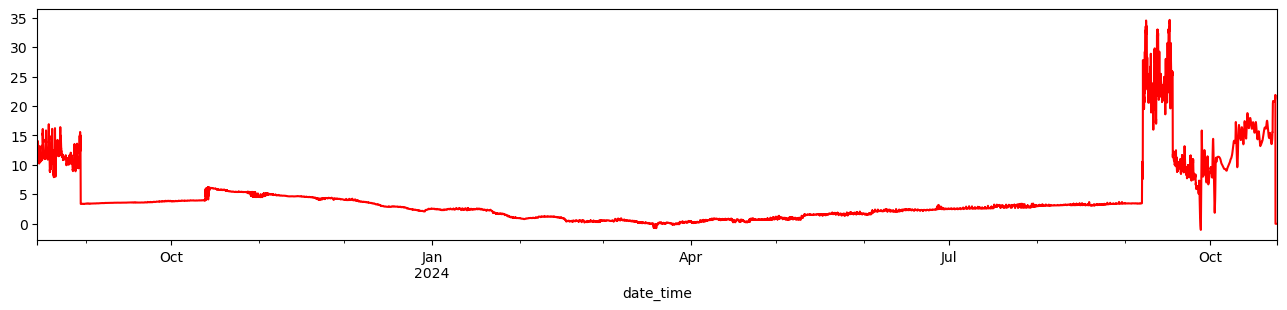

In [10]:
fig, ax = plt.subplots(1,figsize=(16, 3))
mtr_wop_df.temperature.plot(ax=ax,color='r')

## Add Deployment meta information

In [11]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [12]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'MTR',
 'SerialNo': '4118',
 'DesignedDepth': 40.0,
 'ActualDepth': 37.0,
 'PreDeploymentNotes': '',
 'PostDeploymentNotes': '',
 'Deployed': 'y',
 'Recovered': ''}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [13]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [14]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [15]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
mtr_wop_nc = ncCFsave.EcoFOCI_CFnc(df=mtr_wop_df, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config, 
                                operation_type='mooring',
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
mtr_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [16]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
mtr_wop_nc.expand_dimensions()

In [17]:
mtr_wop_nc.variable_meta_data(variable_keys=list(mtr_wop_df.columns.values),drop_missing=True)
mtr_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
mtr_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [18]:
#add global attributes
mtr_wop_nc.deployment_meta_add()
mtr_wop_nc.get_xdf()

#add instituitonal global attributes
mtr_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
mtr_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
mtr_wop_nc.provinance_meta_add()

#provide intial qc status field
mtr_wop_nc.qc_status(qc_status='unknown')



## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [19]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+instrument.split(' ')[-1]+'_'+depth+'m.nc'
mtr_wop_nc.xarray2netcdf_save(xdf = mtr_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe39_wop_nc.xarray2netcdf_save(xdf = sbe39_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'minutes' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})


In [20]:
mtr_wop_nc.autotrim_time()

<xarray.Dataset>
Dimensions:      (time: 53822, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time         (time) datetime64[ns] 2023-08-30T04:20:00 ... 2024-09-06T22:...
  * latitude     (latitude) float64 57.87
  * longitude    (longitude) float64 -168.9
  * depth        (depth) float64 37.0
Data variables:
    temperature  (time, depth, latitude, longitude) float64 3.453 3.41 ... 3.502
Attributes: (12/33)
    Latitude_DegMMddW:                      57 51.983 N
    Longitude_DegMMddN:                     168 52.432 W
    MooringID:                              23BS-4A
    platform_deployment_date:               2023-08-30T04:13:00Z
    platform_deployment_cruise_name:        AQ2301
    platform_recovery_date:                 2024-09-06T22:30:00Z
    ...                                     ...
    InstrumentSerialNumber:                 4118
    InstrumentType:                         MTR
    date_created:                           2024-10-24T14:15:51Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

<Figure size 640x480 with 0 Axes>

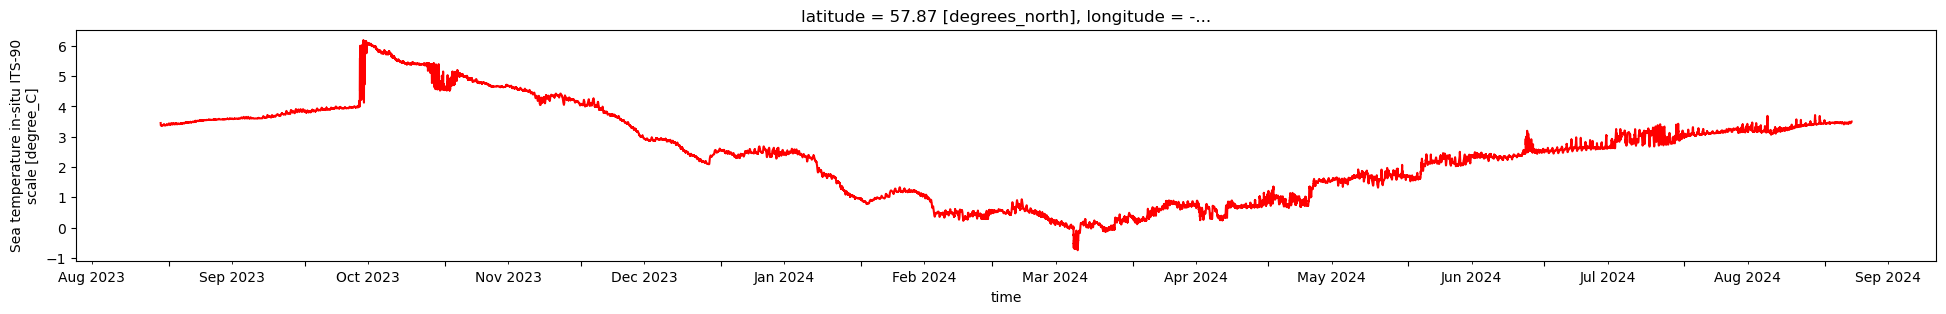

In [21]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,figsize=(24, 3), sharex=True)
mtr_wop_nc.autotrim_time().temperature.plot(ax=ax,color='r')


# xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

In [22]:
#csvoutput if necessary
(mtr_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history